This notebook estimates bus arrival time using gaussian processes.

First off lets get some libraries into scope, set the seed and load the data.

In [1]:
import gpflow
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import time
from datetime import datetime
from sklearn.preprocessing import StandardScaler

sns.set(style="darkgrid")
np.random.seed(1)
df = pd.read_pickle('data.pkl')

That's a lot of data (4 gb). Let's look at just one trajectory and plot the coordinates

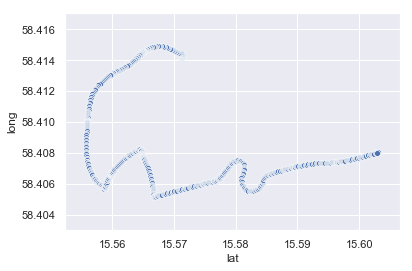

In [2]:
traj_one_df = df[df.traj == 1]
traj_one_df = traj_one_df[1:681] # Filter out all the garbage data on indicies 3464837 etc
sns.scatterplot(x="lat", y="long", data=traj_one_df)

It looks nice! We can also visualise the segments and their time remaining to next bus stop

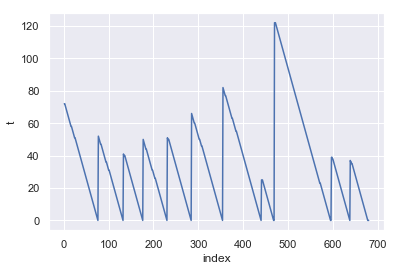

In [3]:
# All segments
traj_one_df['index'] = traj_one_df.index
sns.lineplot(data=traj_one_df, x='index', y='t')

Let's try to learn the synchronisation function for a segment, but first lets plot it

Segment spatially

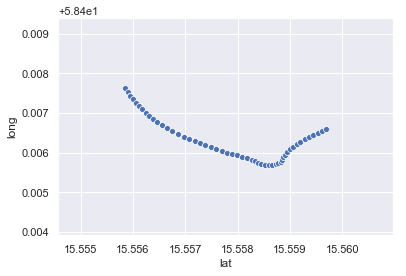

In [59]:
seg = traj_one_df[traj_one_df.seg ==5]
sns.scatterplot(x="lat", y="long", data=seg)

Segment time until arrival

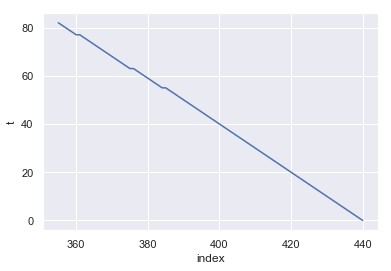

In [52]:

sns.lineplot(data=seg, x='index', y='t')

Segment spatially scaled to zero mean and unit variance

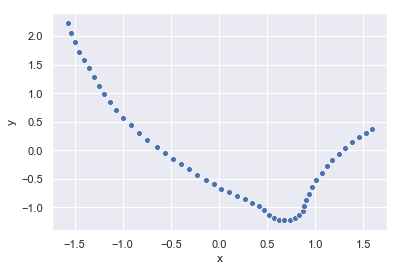

In [60]:
X_unnorm = np.vstack((seg['lat'], seg['long'])).T 
scaler = StandardScaler().fit(X_unnorm)
X = scaler.transform(X_unnorm)

norm_traj= pd.DataFrame(X, columns = list('xy'))
sns.scatterplot(x='x', y='y', data=norm_traj)


In [ ]:
For this we need to learn the function f : R^2 -> [0, 1] so we will use a bivariate GP model

In [61]:
k = gpflow.kernels.Matern52(2, lengthscales=0.3, variance=0.01, ARD=True)
Y = 1 - np.array(seg['t']).reshape(seg.shape[0],1) / seg['t'].max() # Temporal progress
m = gpflow.models.GPR(X, Y, k)
m.likelihood.variance = 0.001
m.compile()

opt = gpflow.train.ScipyOptimizer()
opt.minimize(m)
m.as_pandas_table()

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -181.619225
  Number of iterations: 19
  Number of functions evaluations: 22


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -181.619225
  Number of iterations: 19
  Number of functions evaluations: 22


,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/lengthscales,Parameter,None,+ve,True,"(2,)",True,"[2.7784565980951275, 4.754324037724963]"
GPR/kern/variance,Parameter,None,+ve,True,(),True,0.2966608993758501
GPR/likelihood/variance,Parameter,None,+ve,True,(),True,1.463036802384683e-05


Lets plot the fits mean vs progress. These should be linear if the function maps correctly

C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


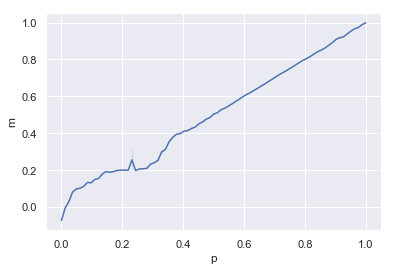

In [55]:
mean, var = m.predict_y(X)
progress_df = pd.DataFrame(np.hstack([X,Y,mean]), columns=list('xypm'))
sns.lineplot(x ='p', y='m', data=progress_df)

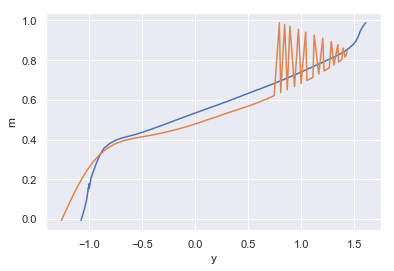

In [41]:
#seg_plot
sns.lineplot(x='x', y='m', data=progress_df)
sns.lineplot(x='y', y='m', data=progress_df)


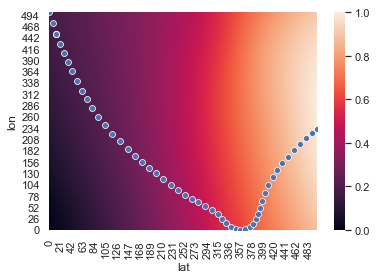

In [62]:
# Plot of posterior mean
latmax = X[:,0].max()
latmin = X[:,0].min()
longmax = X[:,1].min()
longmin = X[:,1].max()
d = 500
xlist = np.linspace(latmin, latmax, d)
ylist = np.linspace(longmin, longmax, d)
xx, yy = np.meshgrid(xlist, ylist)
grid = np.array([np.reshape(xx,(-1,)).T,np.reshape(yy,(-1,))]).T
mean, var = m.predict_y(grid)


lat_unnorm = seg['lat']
lon_unnorm = seg['long']
lat_grid = ((lat_unnorm-lat_unnorm.min())/(lat_unnorm.max() - lat_unnorm.min()))*d
lon_grid = ((lon_unnorm-lon_unnorm.min())/(lon_unnorm.max() - lon_unnorm.min()))*d
df_grid = pd.DataFrame({'lat':lat_grid, 'lon': lon_grid})
hm = sns.heatmap(mean.reshape(d,d), vmin= 0, vmax=1)
hm.invert_yaxis()
sns.scatterplot(x='lat', y='lon', data=df_grid)


In [ ]:
sns.lineplot(x='lat', y='')

In [162]:
np.random.seed(0)
df = pd.DataFrame({'x' : xlist, "y" : ylist, "z":mean})
print(df)
binsx = np.arange(0,112.5,12.5)
binsy = np.arange(0,120,20)
res = df.groupby([pd.cut(df.y, binsy),pd.cut(df.x,binsx)])['z'].mean().unstack()

plt.imshow(res, cmap=plt.cm.Reds, 
           extent=[binsx.min(), binsx.max(),binsy.min(),binsy.max()])
plt.xticks(binsx)
plt.yticks(binsy)
plt.colorbar()
plt.grid(False)


plt.show()


(500,)


Exception: Data must be 1-dimensional